# NonViscous MFG-LWR 

In [1]:
import numpy as np
from scipy import integrate
import numdifftools as nd
from scipy.optimize.nonlin import newton_krylov
import scipy.sparse.linalg as spla
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

In [2]:
''' inputs '''
T=3 # horizon length 
N=1 # number of cars 
u_max=1 # free flow speed
rho_jam=1 # jam density
L=N # road length
CFL=0.75    # CFL<1
rho_a=0.05; rho_b=0.95; gama=0.1
""" Non-viscous solution""" 
ep1=0  # rho
ep2=0  # V
Error_list=[]
Nx_list=[]

In [3]:
def U(rho): # Greenshields desired speed
    return u_max*(1-rho/rho_jam)

def f_star(p,r): # p=Vx
    return -0.5*(p**2)+U(r)*p # MFG-LWR

def f_star_p(p,r): # 0<=u<=u_max
    return U(r)-p # MFG-LWR

def integral(a,b): 
    x2 = lambda x: rho_int(x)
    I=integrate.quad(x2, a, b)
#     result=max(min(I[0],rho_jam),0) # 0<  <=rho_jam
    return I[0]

def rho_int(s): # initial density
    return rho_a+(rho_b-rho_a)*np.exp(-0.5*((s-0.5*L)/gama)**2) # 0<=rho<=rho_jam

def VT(a): # Terminal cost
    return 0

def F(w):
    # FF=[F_rho,F_u,F_V,F_rho_int,F_V_ter], F_rho:0->Nt*Nx-1, F_u:Nt*Nx->2*Nt*Nx-1, F_V:2*Nt*Nx->3*Nt*Nx-1, F_rho_int:3*Nt*Nx->3*Nt*Nx+Nx-1, F_V_ter:3*Nt*Nx+Nx->3*Nt*Nx+2*Nx-1
    FF=np.zeros(3*Nt*Nx+2*Nx)
    for n in range(0,Nt):
        # F_rho , F[0]->F[Nt-1] ************** 1
        FF[n]=w[n+1]-0.5*w[n+Nt+1]+(0.5*dt/dx)*w[n+Nt+1]*w[n+(Nt+1)*Nx+Nt]+ep1*(w[n+Nt+1]-2*w[n])
        # F_rho , F[Nt*Nx-Nt]->F[Nt*Nx-1] ********** 3
        FF[Nt*(Nx-1)+n]=w[(Nt+1)*(Nx-1)+n+1]-0.5*w[(Nt+1)*(Nx-2)+n]-(0.5*dt/dx)*w[(Nt+1)*(Nx-2)+n]*w[(Nt+1)*Nx+(Nx-2)*Nt+n]+ep1*(-2*w[(Nt+1)*(Nx-1)+n]+w[(Nt+1)*(Nx-2)+n])
        # F_u , F[Nt*Nx]->F[Nt*Nx+Nt-1] *********** 4
        FF[Nt*Nx+n]=w[(Nt+1)*Nx+n]-f_star_p(w[(2*Nt+1)*Nx+n+1]/dx,w[n])
        # F_u , F[2*Nt*Nx-Nt]->F[2*Nt*Nx-1] ********* 6
        FF[2*Nt*Nx-Nt+n]=w[2*Nt*Nx+Nx-Nt+n]-f_star_p((w[3*Nt*Nx+2*Nx-Nt+n]-w[3*Nt*Nx+2*Nx-2*Nt+n-1])/dx,w[Nt*Nx+Nx-Nt+n-1])
        # F_V , F[2*Nt*Nx]->F[2*Nt*Nx+Nt-1] *********** 7
        FF[2*Nt*Nx+n]=w[(2*Nt+1)*Nx+n+1]-w[(2*Nt+1)*Nx+n]+dt*f_star(w[(2*Nt+1)*Nx+n+1]/dx,w[n])+ep2*(w[(2*Nt+1)*Nx+Nt+n+2]-2*w[(2*Nt+1)*Nx+n+1])
        # F_V , F[3*Nt*Nx-Nt]->F[3*Nt*Nx-1] ********** 9
        FF[3*Nt*Nx-Nt+n]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n]+dt*f_star((w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])/dx,w[(Nx-1)*(Nt+1)+n])+ep2*(-2*w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])
    for j in range(2,Nx):
        for n in range(0,Nt):
            # F_rho , F[Nt]->F[Nt*Nx-Nt-1] ************ 2
            FF[(j-1)*Nt+n]=w[(j-1)*(Nt+1)+n+1]-0.5*(w[(j-2)*(Nt+1)+n]+w[j*(Nt+1)+n])+(0.5*dt/dx)*(w[j*(Nt+1)+n]*w[(Nt+1)*Nx+j*Nt+n]-w[(j-2)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-2)*Nt+n])+ep1*(w[j*(Nt+1)+n]-2*w[(j-1)*(Nt+1)+n]+w[(j-2)*(Nt+1)+n])
            # F_u , F[Nt*Nx+Nt]->F[2*Nt*Nx-Nt-1] *********** 5
            FF[(j-1)*Nt+Nt*Nx+n]=w[(Nt+1)*Nx+(j-1)*Nt+n]-f_star_p((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])
            # F_V , F[2*Nt*Nx+Nt]->F[3*Nt*Nx-Nt-1] ********* 8
            FF[(j-1)*Nt+2*Nt*Nx+n]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]+dt*f_star((w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])/dx,w[(j-1)*(Nt+1)+n])+ep2*(w[(2*Nt+1)*Nx+j*(Nt+1)+n+1]-2*w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])
        # F_rho_int , F[3*Nt*Nx+1]->F[3*Nt*Nx+Nx-2] ********** 11
        FF[3*Nt*Nx+j-1]=w[(j-1)*(Nt+1)]-(1/dx)*integral(x[j-1],x[j])
        # F_V_ter , F[3*Nt*Nx+Nx+1]->F[3*Nt*Nx+2*Nx-2] ********* 14
        FF[3*Nt*Nx+Nx+j-1]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]-VT(x[j])
    # F_rho_int , F[3*Nt*Nx] ********* 10
    FF[3*Nt*Nx]=w[0]-(1/dx)*integral(x[0],x[1])
    # F_rho_int , F[3*Nt*Nx+Nx-1] ********* 12
    FF[3*Nt*Nx+Nx-1]=w[(Nx-1)*(Nt+1)]-(1/dx)*integral(x[Nx-1],x[Nx])
    # F_V_ter , F[3*Nt*Nx+Nx] *********** 13 
    FF[3*Nt*Nx+Nx]=w[(2*Nt+1)*Nx+Nt]-VT(x[1])
    # F_V_ter , F[3*Nt*Nx+2*Nx-1] ************** 15
    FF[3*Nt*Nx+2*Nx-1]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+Nt]-VT(x[Nx])
    
    return FF

def Fapp(w): # Ignoring the forward-backward coupling  parts
    # FF=[F_rho,F_u,F_V,F_rho_int,F_V_ter], F_rho:0->Nt*Nx-1, F_u:Nt*Nx->2*Nt*Nx-1, F_V:2*Nt*Nx->3*Nt*Nx-1, F_rho_int:3*Nt*Nx->3*Nt*Nx+Nx-1, F_V_ter:3*Nt*Nx+Nx->3*Nt*Nx+2*Nx-1
    FF=np.zeros(3*Nt*Nx+2*Nx)
    for n in range(0,Nt):
        # F_rho , F[0]->F[Nt-1] ************** 1
        FF[n]=w[n+1]-0.5*w[n+Nt+1]+(0.5*dt/dx)*w[n+Nt+1]*w[n+(Nt+1)*Nx+Nt]+ep1*(w[n+Nt+1]-2*w[n])
        # F_rho , F[Nt*Nx-Nt]->F[Nt*Nx-1] ********** 3
        FF[Nt*(Nx-1)+n]=w[(Nt+1)*(Nx-1)+n+1]-0.5*w[(Nt+1)*(Nx-2)+n]-(0.5*dt/dx)*w[(Nt+1)*(Nx-2)+n]*w[(Nt+1)*Nx+(Nx-2)*Nt+n]+ep1*(-2*w[(Nt+1)*(Nx-1)+n]+w[(Nt+1)*(Nx-2)+n])
        # F_u , F[Nt*Nx]->F[Nt*Nx+Nt-1] *********** 4
        FF[Nt*Nx+n]=w[(Nt+1)*Nx+n]
        # F_u , F[2*Nt*Nx-Nt]->F[2*Nt*Nx-1] ********* 6
        FF[2*Nt*Nx-Nt+n]=w[2*Nt*Nx+Nx-Nt+n]
        # F_V , F[2*Nt*Nx]->F[2*Nt*Nx+Nt-1] *********** 7
        FF[2*Nt*Nx+n]=w[(2*Nt+1)*Nx+n+1]-w[(2*Nt+1)*Nx+n]+ep2*(w[(2*Nt+1)*Nx+Nt+n+2]-2*w[(2*Nt+1)*Nx+n+1])
        # F_V , F[3*Nt*Nx-Nt]->F[3*Nt*Nx-1] ********** 9
        FF[3*Nt*Nx-Nt+n]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n]+ep2*(-2*w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(Nx-2)*(Nt+1)+n+1])
    for j in range(2,Nx):
        for n in range(0,Nt):
            # F_rho , F[Nt]->F[Nt*Nx-Nt-1] ************ 2
            FF[(j-1)*Nt+n]=w[(j-1)*(Nt+1)+n+1]-0.5*(w[(j-2)*(Nt+1)+n]+w[j*(Nt+1)+n])+(0.5*dt/dx)*(w[j*(Nt+1)+n]*w[(Nt+1)*Nx+j*Nt+n]-w[(j-2)*(Nt+1)+n]*w[(Nt+1)*Nx+(j-2)*Nt+n])+ep1*(w[j*(Nt+1)+n]-2*w[(j-1)*(Nt+1)+n]+w[(j-2)*(Nt+1)+n])
            # F_u , F[Nt*Nx+Nt]->F[2*Nt*Nx-Nt-1] *********** 5
            FF[(j-1)*Nt+Nt*Nx+n]=w[(Nt+1)*Nx+(j-1)*Nt+n]
            # F_V , F[2*Nt*Nx+Nt]->F[3*Nt*Nx-Nt-1] ********* 8
            FF[(j-1)*Nt+2*Nt*Nx+n]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]-w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]+ep2*(w[(2*Nt+1)*Nx+j*(Nt+1)+n+1]-2*w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n+1]+w[(2*Nt+1)*Nx+(j-2)*(Nt+1)+n+1])
        # F_rho_int , F[3*Nt*Nx+1]->F[3*Nt*Nx+Nx-2] ********** 11
        FF[3*Nt*Nx+j-1]=w[(j-1)*(Nt+1)]-(1/dx)*integral(x[j-1],x[j])
        # F_V_ter , F[3*Nt*Nx+Nx+1]->F[3*Nt*Nx+2*Nx-2] ********* 14
        FF[3*Nt*Nx+Nx+j-1]=w[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]-VT(x[j])
    # F_rho_int , F[3*Nt*Nx] ********* 10
    FF[3*Nt*Nx]=w[0]-(1/dx)*integral(x[0],x[1])
    # F_rho_int , F[3*Nt*Nx+Nx-1] ********* 12
    FF[3*Nt*Nx+Nx-1]=w[(Nx-1)*(Nt+1)]-(1/dx)*integral(x[Nx-1],x[Nx])
    # F_V_ter , F[3*Nt*Nx+Nx] *********** 13 
    FF[3*Nt*Nx+Nx]=w[(2*Nt+1)*Nx+Nt]-VT(x[1])
    # F_V_ter , F[3*Nt*Nx+2*Nx-1] ************** 15
    FF[3*Nt*Nx+2*Nx-1]=w[(2*Nt+1)*Nx+(Nx-1)*(Nt+1)+Nt]-VT(x[Nx])
    
    return FF


def get_preconditioner(a):
    Jac=nd.Jacobian(Fapp)
    J1=Jac(a)
    # the *incomplete LU* decomposition
    J1_ilu = spla.spilu(J1)
    # matrix-vector product -> LinearOperator 
    M_x = lambda r: J1_ilu.solve(r)
    M = spla.LinearOperator(J1.shape, M_x)

    return M
    

def interpol(Nt,Nt_mul,Nx,Nx_mul,w): # 1D interpolation
    
    """" Go from a coarse grid Nt*Nx to a finer grid spacing (Nt_mul*Nt)*(Nx_mul*Nx) """""

    # method 2
    n=w.shape[0] # n=3Nt*Nx+2Nx
    i = np.indices(w.shape)[0]/(n-1)  # [0, ..., 1]
    new_n = 3*(Nt_mul*Nt)*(Nx_mul*Nx)+2*(Nx_mul*Nx)
    print('n={n}, new_n={new_n}'.format(n=n,new_n=new_n))
    new_i = np.linspace(0, 1, new_n)
    new_w=griddata(i, w, new_i, method="cubic")  # method{‘linear’, ‘nearest’, ‘cubic’}
    
    return Nt_mul*Nt, Nx_mul*Nx, new_w

def solution(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,Nt):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,Nt]=sol[(j-1)*(Nt+1)+Nt]
        V[j,Nt]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
    for n in range(0,Nt+1): # periodic boundary conditions
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
    for n in range(0,Nt):
        u[0,n]=f_star_p(V[1,n]/dx,rho[0,n])
        Q[0,n]=rho[0,n]*u[0,n]
#     print("rho=",rho)
#     print("u=",u)
#     print("V=",V)
    return 0

def plotting(text,t,x,rho,u,V,Q,Nx_list,Error_list):
    tt, xx = np.meshgrid(t, x)
    fig = plt.figure(figsize=(6, 5), dpi=100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('density')
    ax.invert_xaxis()
    ax.text2D(0.05, 0.95, text, transform=ax.transAxes)

    plt.figure(figsize=(25, 5))
    plt.subplot(1,4,1)
    plt.plot(x,rho[:,0],label='density')
    plt.plot(x,u[:,0],label='speed')
    plt.plot(x,V[:,0],label='Optimal cost')
    plt.legend()
    plt.grid()
    plt.title("t=0, T={T}".format(T=T))
    plt.xlabel('x')
    plt.subplot(1,4,2)
    plt.plot(x,rho[:,Nt-1],label='density')
    plt.plot(x,u[:,Nt-1],label='speed')
    plt.plot(x,V[:,Nt-1],label='Optimal cost')
    plt.grid()
    plt.legend()
    plt.title("t={t}, T={T}".format(t=round(t[Nt-1],3),T=T))
    plt.xlabel('x')
    plt.subplot(1,4,3)
    plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
    plt.xlabel('density')
    plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (T={T})".format(T=T))
    plt.subplot(1,4,4)
    plt.plot(Nx_list,Error_list,label='MFG-LWR')
    plt.xlabel('Spatial grid size')
    plt.ylabel('error')
    plt.grid()
    plt.title("convergence of solution algorithm")
    return 0

def convergence(guess,sol,o):
    rho=np.zeros((Nx+1,Nt+1))
    u=np.zeros((Nx+1,Nt))
    V=np.zeros((Nx+1,Nt+1))
    Q=np.zeros((Nx+1,Nt))
    solution(guess,rho,u,V,Q)
    rho_LWR=np.zeros((Nx+1,Nt+1))
    u_LWR=np.zeros((Nx+1,Nt))
    V_LWR=np.zeros((Nx+1,Nt+1))
    Q_LWR=np.zeros((Nx+1,Nt))
    solution(sol,rho_LWR,u_LWR,V_LWR,Q_LWR)
    error=np.linalg.norm(rho_LWR-rho,ord=o)/np.linalg.norm(rho_LWR,ord=o)+np.linalg.norm(u_LWR-u,ord=o)/np.linalg.norm(u_LWR,ord=o)
    return error

## MFG-LWR

In [4]:
""" solve in coarse grid """
Nx=20; Nt=10 # spatial-temporal grid sizes 
dx=L/Nx # spatial step size
dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
guess0 = np.zeros(3*Nt*Nx+2*Nx)
# t0 = time.process_time()   ###
sol0 = newton_krylov(F, guess0, method='lgmres', verbose=1, inner_M=get_preconditioner(guess0))
# print('sol0=',sol0)
""" Error 0 """
error0=convergence(guess0,sol0,1)
Error_list.append(error0)
Nx_list.append(Nx)

dx=0.05, dt=0.038
0:  |F(x)| = 0.0637568; step 1
1:  |F(x)| = 0.0193471; step 1
2:  |F(x)| = 0.000321357; step 1
3:  |F(x)| = 2.2204e-08; step 1


/home/amal/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [7]:
""" solve in finer grid 1 """
Nt, Nx, guess1=interpol(Nt,2,Nx,2,sol0)
# print('guess1=',guess1)
dx=L/Nx # spatial step size
dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
sol1 = newton_krylov(F, guess1, method='lgmres', verbose=1, inner_M=get_preconditioner(guess1))
# print('sol1=',sol1)
""" Error 1 """
error1=convergence(guess1,sol1,1)
Error_list.append(error1)
Nx_list.append(Nx)

n=640, new_n=2480
dx=0.025, dt=0.019


/home/amal/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:407: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


0:  |F(x)| = 0.109936; step 1
1:  |F(x)| = 0.0739899; step 1
2:  |F(x)| = 0.00206444; step 1
3:  |F(x)| = 0.00192265; step 1
4:  |F(x)| = 2.00661e-06; step 1


In [ ]:
""" solve in finer grid 2 """
Nt, Nx, guess2=interpol(Nt,2,Nx,2,sol1)
# print('guess2=',guess2)
dx=L/Nx # spatial step size
dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
sol2 = newton_krylov(F, guess2, method='lgmres', verbose=1, inner_M=get_preconditioner(guess2))
# print('sol2=',sol2)
""" Error 2 """
error2=convergence(guess2,sol2,1)
Error_list.append(error2)
Nx_list.append(Nx)

n=2480, new_n=9760
dx=0.013, dt=0.009


In [ ]:
""" solve in finer grid 3 """
Nt, Nx, guess3=interpol(Nt,2,Nx,2,sol2)
dx=L/Nx # spatial step size
dt=min(T/Nt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,3),dt=round(dt,3)))
x=np.linspace(0,L,Nx+1)
t=np.linspace(0,T,Nt+1)
sol3 = newton_krylov(F, guess3, method='lgmres', verbose=1, inner_M=get_preconditioner(guess3))
# t1 = time.process_time()   ###
# print("Time spent", t1 - t0)
# print('sol3=',sol3)
""" Error 3 """
error3=convergence(guess3,sol3,1)
Error_list.append(error3)
Nx_list.append(Nx)

In [8]:
""" Solutions """
rho_LWR=np.zeros((Nx+1,Nt+1))
u_LWR=np.zeros((Nx+1,Nt))
V_LWR=np.zeros((Nx+1,Nt+1))
Q_LWR=np.zeros((Nx+1,Nt))
solution(sol1,rho_LWR,u_LWR,V_LWR,Q_LWR)
x_LWR=np.linspace(0,L,Nx+1)
t_LWR=np.linspace(0,T,Nt+1)

<ipython-input-3-a632c8f35aa4>:150: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


0

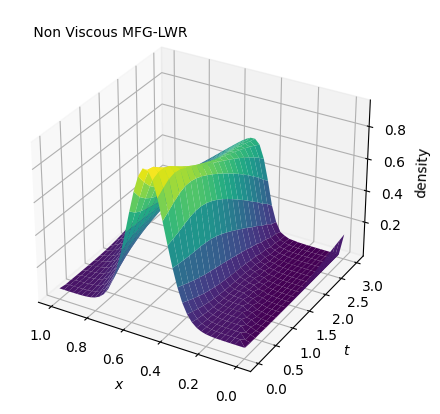

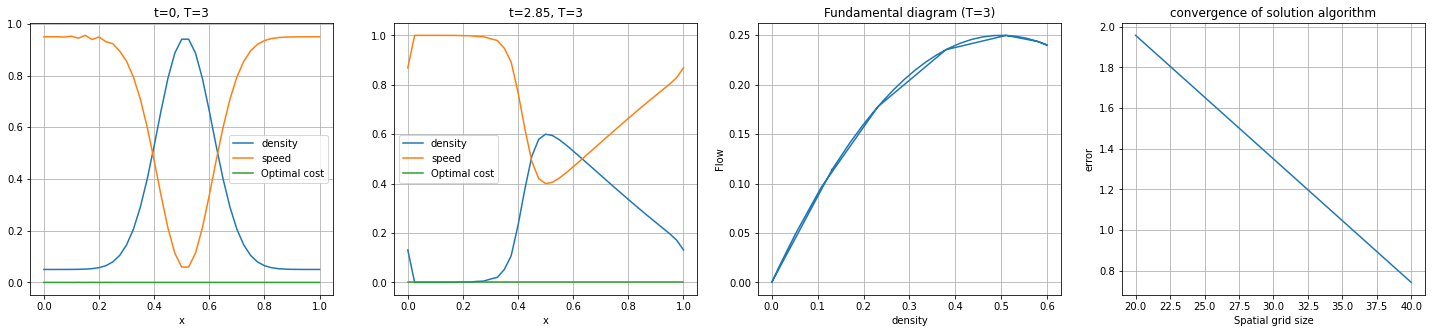

In [9]:
title1="\n Non Viscous MFG-LWR"
plotting(title1,t_LWR,x_LWR,rho_LWR,u_LWR,V_LWR,Q_LWR,Nx_list,Error_list)